# Pricing an Exotic Option

An Exotic Option with the following payoff is given

\begin{equation}
    Max \left[0,\left(\frac{S(T)}{S(0)} - k\right)\left(\frac{L(T-\Delta,T-\Delta,T)}{L(0,T-\Delta,T)}- k'\right)\right]
    \label{eqn:optionPayoff}
\end{equation}



$S(t)$ is the STOXX50E spot price quantoed from EUR into USD in [0,T]

$L(T-\Delta,T-\Delta,T)$ is the 3 month USD LIBOR rate between $T - \Delta$ and T ($\Delta$ = 3 months)

k and k' are relative strike prices and T is the expiration time.



The variables used in this project are described below: 
- `S(0)`  - STOXX50E Price 
- `a`     - constant for short rate 
- `X`     - Strike rate in ZBP 
- `ZBP`   - Zero Base Pricing (Caplet Price) 
- `r(0)`  - Initial short rate estimate (overnight Libor)
- `sig1 ` - STOXX50E at the money volatility
- `sig2`  - Euro-USD at the money volatility
- `q`     - Dividends  
- `r`     - EURUSD risk free rate  
- `rho23` - Eur-USD Correlation 
- `S`     - 9 months time duration
- `T`     - Maturity 1 year (12 months)
- `k1`    - Stock strike
- `k2`    - Libor strike

In [3]:
import numpy             as np 
import matplotlib.pyplot as plt
import pandas            as pd
from   scipy.optimize    import minimize
from scipy.stats         import norm

## Input data

In [2]:
a=0.03
S=0.75
t=0
T=1
X=1.0075
ZBP=0.03


stoxx = pd.read_excel('stockData.xlsx', sheet_name='STOXX')
eurusd = pd.read_excel("stockData.xlsx", sheet_name='EURUSD')
#have to update which is sig1 and 2
eurusd_vol = 4.5225/100 #as per 11/26/2019 
stock = 14.0305/100
overnightLibor =  pd.read_excel("stockData.xlsx", sheet_name='OVERNIGHT LIBOR')
rho_1 = stoxx['Last Price'].corr(eurusd['Last Price'])
rho_2 = stoxx['Last Price'].corr(overnightLibor['Ask Price'])


## Forward rate model

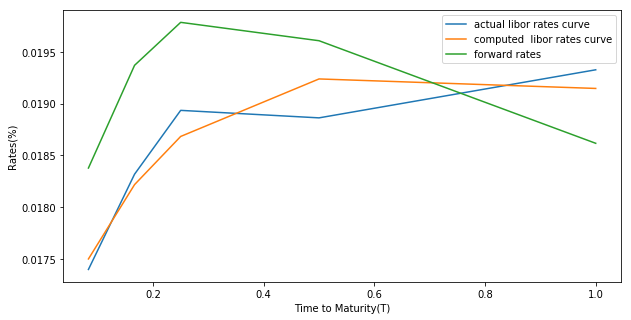

0.0186177376463752

In [3]:
#Libor rates used as spot rates for forward rate curve fitting
time_array = np.array([1./12,2./12,3./12,6./12,1.0])
libor_rates = np.array([1.73975/100 ,1.83188/100 ,1.89363/100,1.88638/100,1.93288/100])  #in USD 

def zcbCurve_obj_func(params,time_array,libor_rates):
    func= params[0] + (params[1]+params[2])*params[3]/time_array * (1 - np.exp(-time_array/params[3])) - params[2]*np.exp(-time_array/params[3])
    return np.sum((libor_rates-func)**2)
def constraint1(param):
    return param[0]
def constraint2(param):
    return param[0]+param[1]
def constraint3(param):
    return param[3]
def get_zcbCurve_params(time_array,libor_rates):
    initial_guess = np.array([0.,0.,0.,0.25])
    cons1 = {'type':'ineq','fun':constraint1}
    cons2 = {'type':'ineq','fun':constraint2}
    cons3 = {'type':'ineq','fun':constraint3}
    cons = [cons1,cons2,cons3]
    return minimize(zcbCurve_obj_func,initial_guess,args=(time_array,libor_rates), method='SLSQP',constraints=cons)
sol = get_zcbCurve_params(time_array,libor_rates).x
def f_star(input_time, plot_curves=False):   
    if plot_curves==True:
        plt.figure(figsize=(10,5))
        plt.plot(time_array,libor_rates, label = 'actual libor rates curve')
        plt.plot(time_array,sol[0] + (sol[1]+sol[2])*sol[3]/time_array * (1 - np.exp(-time_array/sol[3])) - sol[2]*np.exp(-time_array/sol[3]),label='computed  libor rates curve')
        plt.plot(time_array,sol[0] + (sol[1]*np.exp(-time_array/sol[3])) + sol[2]*time_array/sol[3]*np.exp(-time_array/sol[3]),label='forward rates')
        plt.xlabel("Time to Maturity(T)")
        plt.ylabel("Rates(%)")
        plt.legend()
        plt.show()
    return sol[0] + (sol[1]*np.exp(-input_time/sol[3])) + sol[2]*input_time/sol[3]*np.exp(-input_time/sol[3])
def compute_df(T):   
    return 1/sol[3] * np.exp(-T/sol[3])*(-sol[1] + sol[2] * (1 - T/sol[3]))
def p_star(input_time):
    if input_time==0:
        input_time = 0.000000001 #divide by zero error
    spot_rate = sol[0] + (sol[1]+sol[2])*sol[3]/input_time * (1 - np.exp(-input_time/sol[3])) - sol[2]*np.exp(-input_time/sol[3])
    return 1/(1+spot_rate)**input_time
f_star(1, True)

## Fitted forward rate

/Users/chandana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/chandana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


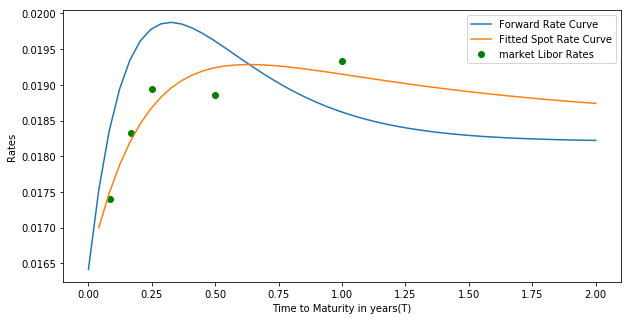

In [4]:
def plot_forward(sol):
    t = np.linspace(0,2)
    y = sol[0] + (sol[1]*np.exp(-t/sol[3])) + sol[2]*t/sol[3]*np.exp(-t/sol[3])
    z = sol[0] + (sol[1]+sol[2])*sol[3]/t * (1 - np.exp(-t/sol[3])) - sol[2]*np.exp(-t/sol[3])
    fig = plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(t,y,label='Forward Rate Curve')
    plt.plot(t,z,label='Fitted Spot Rate Curve')
    plt.scatter(time_array,libor_rates,c='green', label='market Libor Rates')
    plt.xlabel("Time to Maturity in years(T)")
    plt.ylabel("Rates")
    plt.legend()
plot_forward(sol)    

# Get sigma function

In [5]:
p_star_T=p_star(T)
p_star_S=p_star(S)
def B(t,T,a=0.3):
    return (1-np.exp(-a*(T-t)))/a

def get_sigma(t,S,T):
    min_sigma      = minimize(min_func,[0.3],method='SLSQP').x
    sigma          = min_sigma/(((1- np.exp(-2*a*(T-t))/2*a)**0.5)*B(t,T)) #B(t,T) in numerator or denominator
    return sigma[0]
'''
Objective function for minimization problem to get sigma.
Input data: x0: initial guess of sigma
            t: initial time (taken as 0 )
            S: 9-month time marker (taken as 0.75)
            T: time to maturity (taken as 1 in this case)
            X: Strike of the zero coupon bond considered( = 1.0075, source: bloomberg)
            ZBP: caplet price(=0.03, source: bloomberg)
Output: error for minimization problem
'''
def min_func(x0=0.3, t=0,S=0.75,T=1,X=1.0075, ZBP=0.03):

    p_T=p_star_T
    p_S=p_star_S
    sigma_p      =x0
    h            = (1/sigma_p)*(np.log(p_S/(p_T*X))) + (sigma_p/2)
    return [(ZBP-(X*p_T*norm.pdf(-h+sigma_p))+p_T*norm.pdf(-h))**2][0]
get_sigma(t,S,T)

0.3497256119959813

## Present value of ZCB

In [11]:
sig   = get_sigma(t,S,T)
'''
Calculates zero coupon bond prices implied for hull-white short rate model.
Input: t: initial time value
       T: time to maturity
Output: zero coupon bond prices
'''
def p(t,T):
    
    price = (p_star(T) /p_star(t))*np.exp((B(t,T)*f_star(t,False))-((sig**2)/4*a)*(B(t,T))**2*((1-np.exp(-2*a*t)))-B(t,T)*simulate_r_hull(t))
    return price


In [12]:
def get_theta(t,T,S):
    sig = get_sigma(t,S,T)
    theta = compute_df(T) + a* f_star(T,False) + (sig**2)*((1 - np.exp(-2*a*t))/2*a)
    return theta

## Simulating Hull-White model

In [100]:
def simulate_r_hull(t):
    w1  = np.random.normal(0,1,361)

    r   = np.zeros(361)
    dt  = 1/360
    for i in range(1,361):
        r[i] = r[i-1]+( get_theta(i/360,T,S)-a*r[i-1])*dt+sig*(dt**.5)*w1[i-1]
        
#         print(r[i])
    return(r[int(t*359)])

simulate_r_hull(0.2)

/Users/chandana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


-0.1407670107154219

## Simulating Libor rates

In [19]:
def L(t,S,T):
    p_T= p(t,T)
    p_S= p(t,S)
    return -(p_T-p_S)/((T-S)*p_T)


(L(0.75,0.75,1)/L(0,0.75,1))-0.1

/Users/chandana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


-4.485643101039048

In [21]:
l =[]
for i in range(1,1001):
    l+=[(L(0.75,0.75,1)/L(0,0.75,1))-1]
  

/Users/chandana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


[-23.758294561568462, 23.554353293147532, -7.193912064362791, -9.167474184920554, -13.76523617607404, -11.851881644123115, 14.508909705388016, 10.691152863218822, -13.152535927169925, 2.4096510891622405, -10.973414782487838, 14.904824283716845, -16.21427129698541, 4.286417113172413, 8.734082555245866, -7.981411498721671, -2.17734674262722, -1.2373526658362222, 0.7574263370141421, 1.7579169062711704, 3.9985615694952745, 26.966300259044743, 4.717668672548406, 3.056808804402065, 15.309196773643592, 3.2896732299333413, -22.079016234077926, -9.23849335758525, 2.6639292436695414, 7.344512072377087, -5.443151376947638, -3.4858250549900442, 22.94178747235756, -24.873569479805063, -1.816338465610555, 19.83857061391162, 0.3478687557505411, -6.161973966911827, 9.735629104305465, -9.555777904642827, -18.212444247006573, -24.731867339695754, -7.3486479673446805, -27.231580919819173, -9.606944146396636, -15.04039234436612, -4.454564833062916, -0.7312386803988008, 8.099069878899044, -7.41732213918719

## Simulating Price

In [191]:
def price_(s0=3710,r0=0.2,r=0.014,q=0,rho=0.53,sig1=0.11,sig2=0.043):
    p=[]  
    for j in range(1,1000):
        
        s   = np.zeros(361)
        k1 =1
        k2 =1
        
        s[0]= s0    
        dt  = 1/360
        w1  = np.random.normal(0,1,360)
        w2  = np.random.normal(0,1,360)
        
        sig3= np.sqrt(sig1**2+sig2**2+2*rho*sig1*sig2)
        w3  = (sig1*w1+sig2*w2)/sig3
             
        for i in range(1,361):
            s[i] = s[i-1]*(np.exp(((r-q+rho*sig1*sig2)*dt)+(sig3*dt**0.5*w3[i-1])))
            r[i] = r[i-1]+( get_theta(i/360,T,S)-a*r[i-1])+sig*(dt**.5)*w1[i-1]
        
        p.append(np.exp(-r[360])*(max((s[360]/s0-1)*(l[j]),0)))
    
    return np.mean(p)
price_() 

0.44695606190996207


# PLOTS

## Stock Estimation

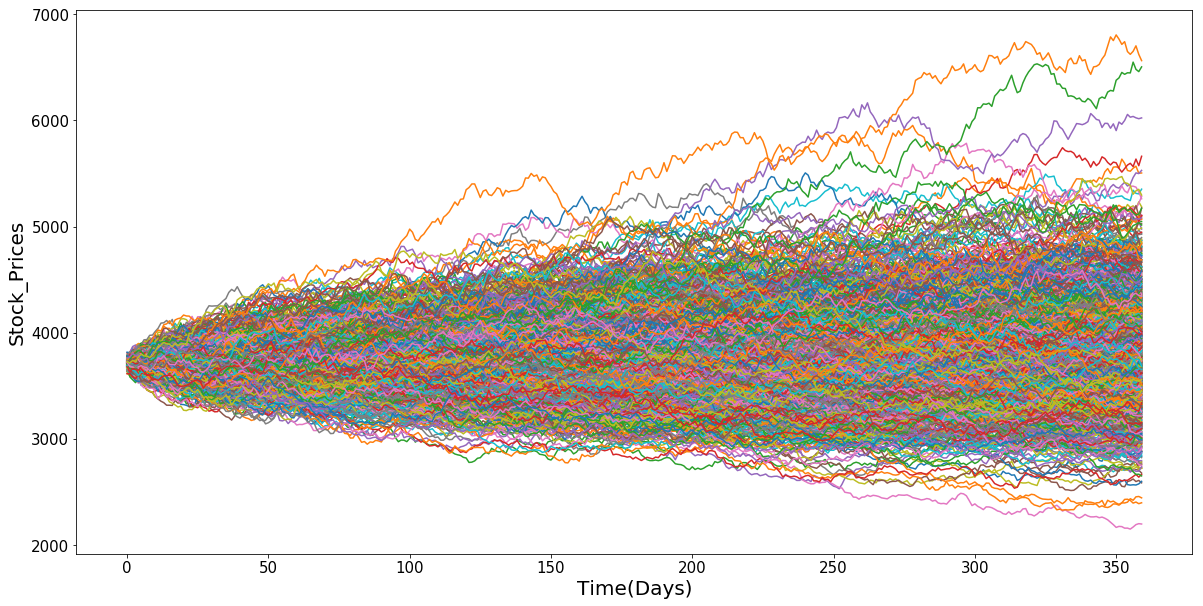

In [55]:
def plot_Stocks(s0=3710,r0=2,r=0.014,q=0,rho=0.53,sig1=0.14,sig2=0.045):
   
    plt.figure(figsize=(20,10))
    plt.xlabel("Time(Days)",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Stock_Prices",fontsize=20)
    
    for j in range(1,1000): 
        x   = []
        k1 =1
        k2 =1
        s = np.zeros(361)
        s[0]=  3710
        dt  = 1/360
        w1  = np.random.normal(0,1,360)
        w2  = np.random.normal(0,1,360)

        sig3= np.sqrt(sig1**2+sig2**2+2*rho*sig1*sig2)

        w3  = (sig1*w1+sig2*w2)/sig3
        for i in range(1,361):
            s[i] = s[i-1]*(np.exp(((r-q+rho*sig1*sig2)*dt)+(sig3*dt**0.5*w3[i-1]))          
            x.append(s[i])     
        plt.plot(x)
   plt.show()
    
plot_Stocks()

### Stock histogram

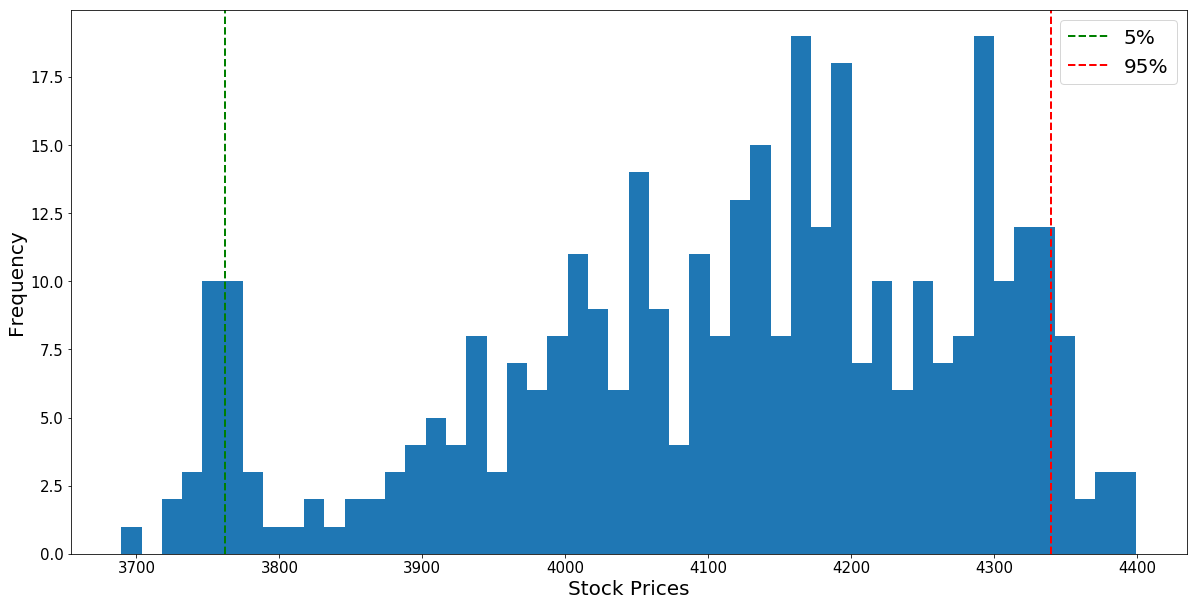

In [47]:
def plot_stock_his(s0=3710,r0=2,r=0.014,q=0,rho=0.53,sig1=0.14,sig2=0.045):    
    plt.figure(figsize=(20,10))
    plt.xlabel("Bins",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Stock_Prices",fontsize=20)
   
    for j in range(1,2):        
        x   = []
        k1 =1
        k2 =1
        s = np.zeros(361)
        s[0]=s0
        dt  = 1/360
        w1  = np.random.normal(0,1,360)
        w2  = np.random.normal(0,1,360)
        sig3= np.sqrt(sig1**2+sig2**2+2*rho*sig1*sig2)
        w3  = (sig1*w1+sig2*w2)/sig3
       
        for i in range(1,361):
            s[i] = s[i-1]*(np.exp(((r-q+rho*sig1*sig2)*dt)+(sig3*dt**0.5*w3[i-1])))            
            x.append(s[i])
           
        plt.hist(x,bins=50)
        plt.axvline(np.percentile(x,5), color='g',label='5%', linestyle='dashed', linewidth=2)
        plt.axvline(np.percentile(x,95), color='r', label='95%',linestyle='dashed', linewidth=2)
        plt.ylabel('Frequency')
        plt.xlabel('Stock Prices')
        plt.legend(prop={'size': 20})

    plt.show()
plot_stock_his()

### Zero Coupon bond path per simulation

/Users/chandana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


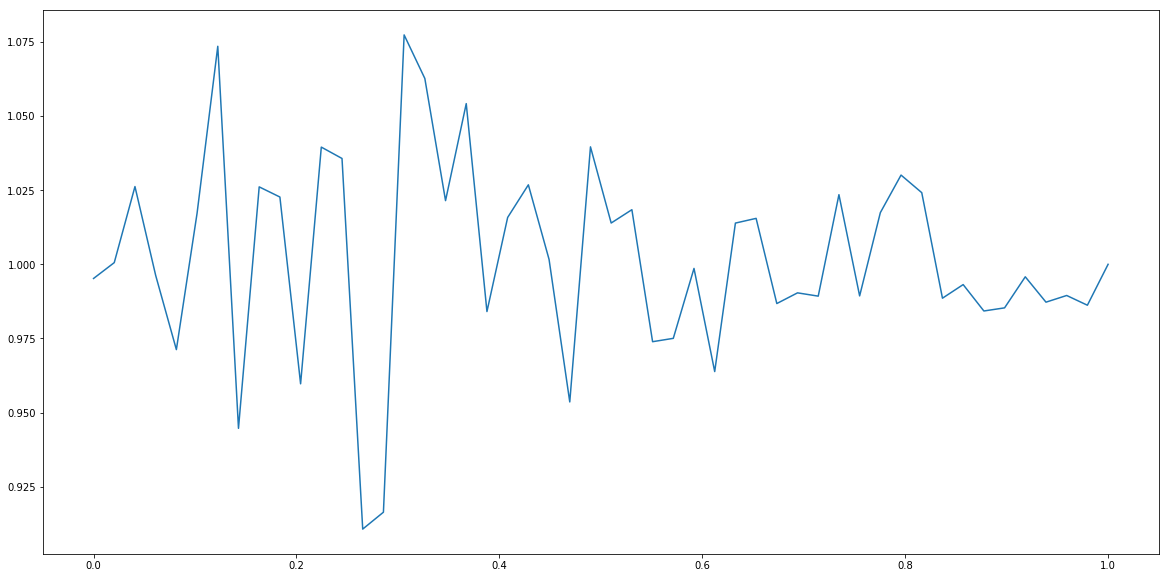

In [49]:
import random
def plot_P():
    random.seed(1234)
    plt.figure(figsize=(20,10))
    time=[]
    bond_price=[]
    T = np.linspace(0,1)
    for i in T:
        bond_price.append(p(i,1))
        time.append(i)
        
    plt.plot(time,bond_price,label='Zero Coupon Bonds')
plot_P()   

### Volatility fit curve for different time to maturities

/Users/chandana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


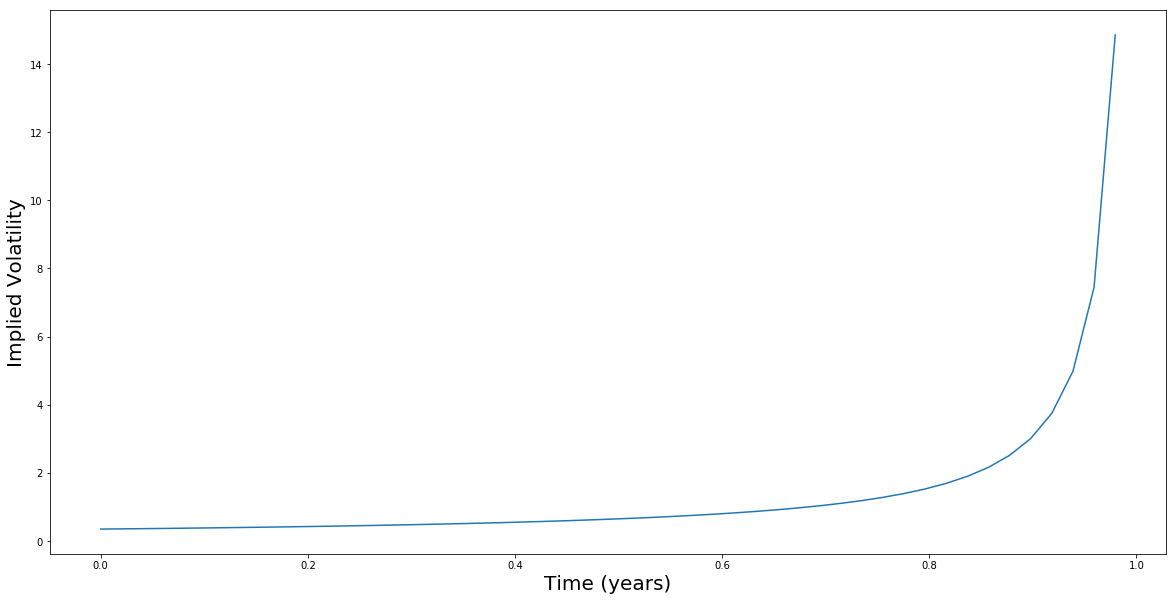

In [56]:
 def plot_Sig():
   
    fig = plt.figure(figsize=(20,10))
    t = np.linspace(0,1)
    time=[]
    sigma=[]
    for i in t:
        time.append(i)
        sigma.append(get_sigma(i,0.75,1))
    
    plt.plot(time,sigma)
    plt.xlabel('Time (years)',fontsize=20)
    plt.ylabel('Implied Volatility',fontsize=20)
plot_Sig()

### Short Rate Hull-White Model Simulation

/Users/chandana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


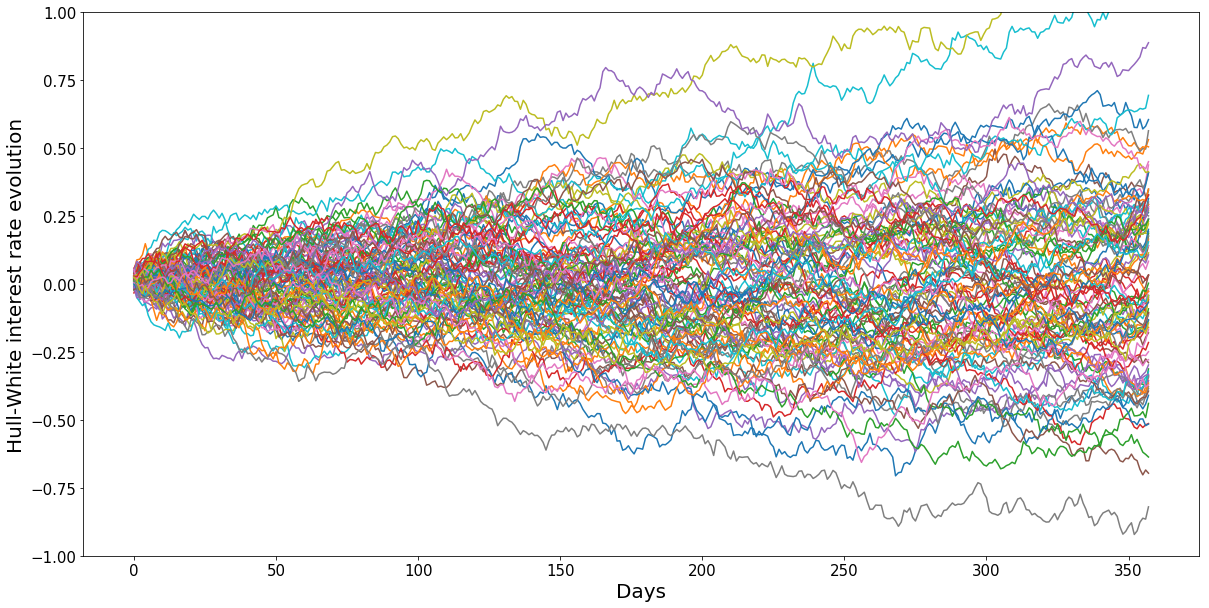

In [123]:
def plot_hull(r0=0.02):
   
    plt.figure(figsize=(20,10))
    plt.ylim(-1, 1)
    plt.xlabel("Days",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Hull-White interest rate evolution",fontsize=20)
    for j in range(1,100):
        w1  = np.random.normal(0,1,361)
        r   = np.zeros(361)
        y   = []
        dt  = 1/360  
        r[0]=r0
        
        for i in range(1,360):
            r[i] = r[i-1]+( get_theta(i/359,T,S)-a*r[i-1])*dt+sig*(dt**.5)*w1[i-1]
#             print(r[i])
            y.append(r[i])
           
        plt.plot(y)
       

    plt.show()
    
plot_hull()  

/Users/chandana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


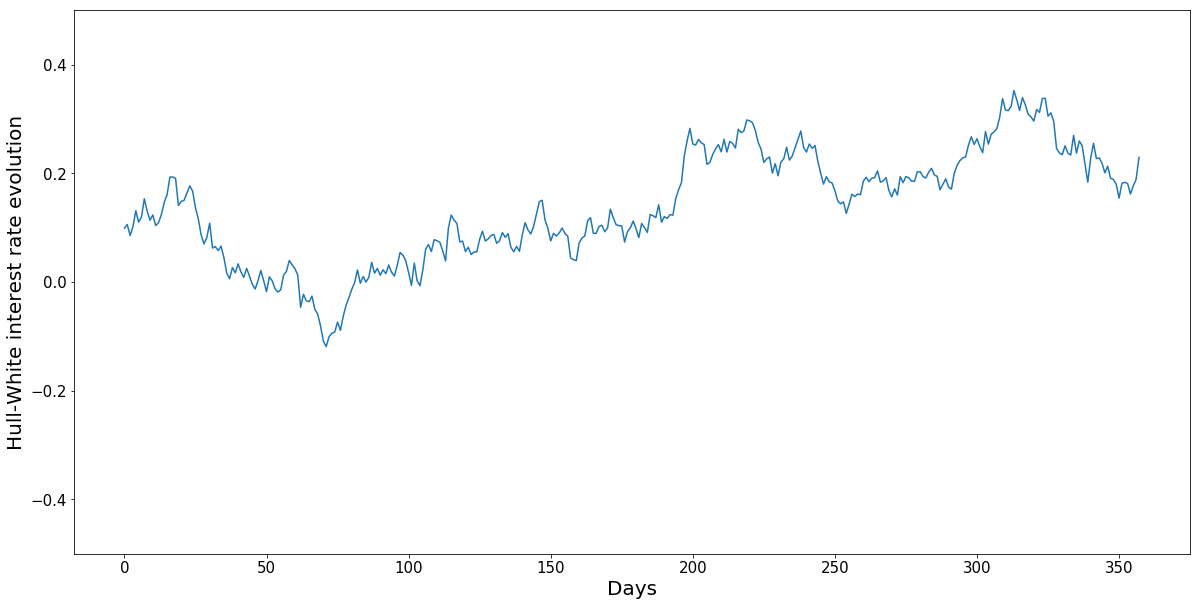

In [120]:
def plot_hull_one(r0=0.1):
   
    plt.figure(figsize=(20,10))
    plt.ylim(-0.5, 0.5)
    plt.xlabel("Days",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Hull-White interest rate evolution",fontsize=20)
    for j in range(1,2):
        w1  = np.random.normal(0,1,361)
        r   = np.zeros(361)
        y   = []
        dt  = 1/360  
        r[0]=r0
        
        for i in range(1,360):
            r[i] = r[i-1]+( get_theta(i/359,T,S)-a*r[i-1])*dt+sig*(dt**.5)*w1[i-1]
#             print(r[i])
            y.append(r[i])
           
        plt.plot(y)
        
#     plt.plot(np.mean(y))
    plt.show()
plt.savefig('Hull-white_onesimulation.png')
    
plot_hull_one()  


### Rate Histogram

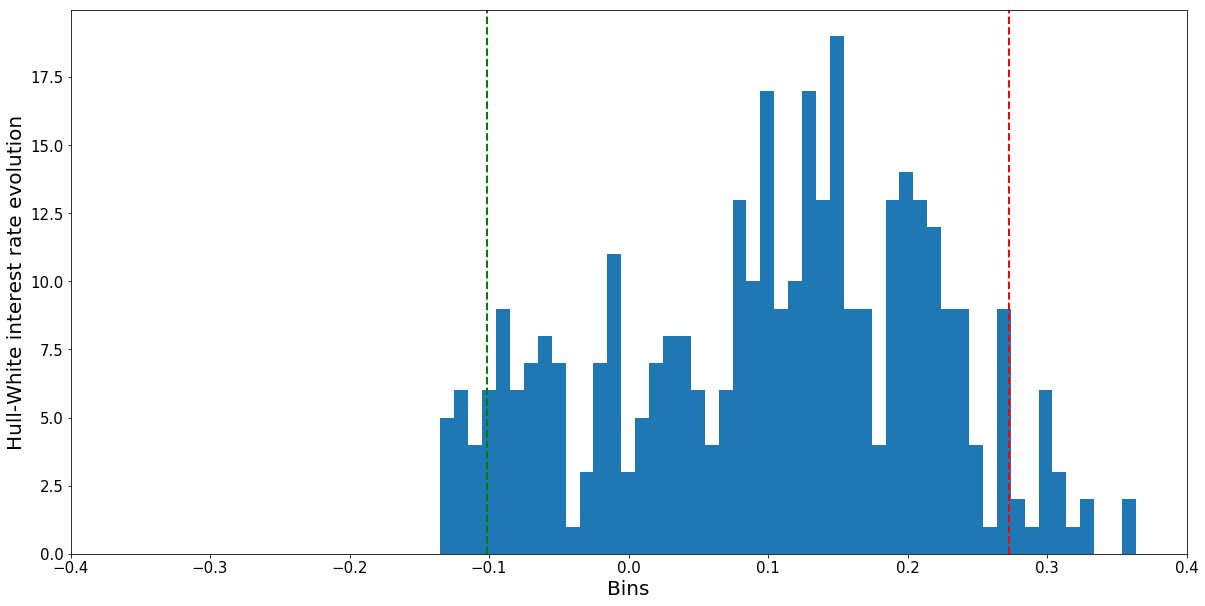

In [126]:
def plot_hull_hist(r0=0.1):
   
    plt.figure(figsize=(20,10))
    plt.xlim(-.4, .4)
    plt.xlabel("Bins",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Hull-White interest rate evolution",fontsize=20)
   
    for j in range(1,2):
        w1  = np.random.normal(0,1,361)
        r   = np.zeros(361)
        y   = []
        dt  = 1/360  
        r[0]=r0
       
        for i in range(1,359):
            r[i] = r[i-1]+(get_theta(i/359,T,S)-a*r[i-1])*dt+sig*(dt**.5)*w1[i-1]
            y.append(r[i])
           
        plt.hist(y,bins=50)
        plt.axvline(np.percentile(y,5), color='g',label='5%', linestyle='dashed', linewidth=2)
        plt.axvline(np.percentile(y,95), color='r', label='95%',linestyle='dashed', linewidth=2)
        

    plt.show()

plot_hull_hist()  